In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import statsmodels.stats.multitest as mc
from scipy.stats import hypergeom

In [252]:
Metaphlan4_pilot = pd.read_csv('~/Desktop/Metaphlan4_pilot.csv').set_index('Abundance').T
both_participant = pd.read_excel('~/Desktop/both_participant.xlsx', header=None).set_index([0])
metadata_pilot = pd.read_csv('~/Desktop/info.txt', delimiter = "\t",skiprows=1).set_index('Participant ID')
metadata_pilot.loc[:,['fecalcal_ng_ml','diagnosis']]

In [192]:
metadata_pilot = metadata_pilot.loc[both_participant.index,:]
metadata_pilot.index.names = ['Participant ID']
metadata_pilot.reset_index(inplace=True)

In [193]:
fecalcal_info = metadata_pilot.loc[metadata_pilot.data_type == "metagenomics", ["External ID", "Participant ID", "diagnosis", "visit_num", "fecalcal_ng_ml"]].set_index('Participant ID')
fecalcal_info.dropna(inplace= True)
fecalcal_max = fecalcal_info.groupby('Participant ID').agg({'fecalcal_ng_ml':max,'External ID':'first','diagnosis':'first','visit_num':'first'},as_index=False )
fecalcal_max.diagnosis.replace({"Healthy control":"nonIBD","Ulcerative colitis":"UC","Crohn's Disease":"CD"},inplace=True)
fecalcal_max['External ID'] += fecalcal_max.groupby('External ID').cumcount().map({0:'_P', 1:'_PM ', 2:'_PM3'})
fecalcal_max.set_index('External ID',inplace=True)
fecalcal_max

,fecalcal_ng_ml,diagnosis,visit_num
External ID,,,
MSM6J2JF_P,177.050683,nonIBD,1.0
MSM6J2JH_P,12.315746,nonIBD,1.0
MSM6J2N6_P,336.524275,UC,1.0
MSM79H52_P,26.300000,nonIBD,2.0
MSM79HF1_P,301.212462,UC,1.0
MSM79HBX_P,283.833627,CD,1.0
MSM79HD8_P,26.704098,UC,2.0
MSM79H8J_P,14.489295,nonIBD,4.0
MSM9VZFJ_P,12.867972,nonIBD,1.0


In [196]:
Metaphlan4_pilot = Metaphlan4_pilot.loc[fecalcal_max.index,:]
Metaphlan4_pilot = Metaphlan4_pilot.loc[:,Metaphlan4_pilot.columns.str.startswith('s__')]
Metaphlan4_pilot["diagnosis"] =fecalcal_max.diagnosis
Metaphlan4_pilot

Abundance,s__Phocaeicola_dorei,s__Bacteroides_ovatus,s__Phocaeicola_massiliensis,s__Bacteroides_uniformis,s__Bacteroides_stercoris,s__Sutterella_wadsworthensis,s__Parabacteroides_merdae,s__Bacteroides_faecis,s__Faecalibacterium_prausnitzii,s__Bifidobacterium_longum,...,s__Gemmiger_sp_An194,s__Haemophilus_haemolyticus,s__GGB9059_SGB13976,s__GGB4546_SGB6267,s__GGB27782_SGB40196,s__GGB9677_SGB15179,s__GGB27776_SGB40190,s__GGB52930_SGB73859,s__Bacteroides_bouchesdurhonensis,diagnosis
External ID,,,,,,,,,,,,,,,,,,,,,
MSM6J2JF_P,0.89884,7.29835,0.02327,16.23347,0.12430,0.36082,1.59985,0.00000,2.05433,0.11186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonIBD
MSM6J2JH_P,0.60672,0.30225,1.63663,0.86077,0.00000,0.56327,0.00000,0.69763,4.19776,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonIBD
MSM6J2N6_P,0.71148,0.55842,0.00000,0.36165,0.00000,1.72590,0.40616,0.00000,1.46511,0.24510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UC
MSM79H52_P,0.00000,0.74611,0.00000,8.89428,0.00000,0.00000,0.00000,0.96025,0.06517,0.77267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonIBD
MSM79HF1_P,0.73222,0.30829,0.85043,2.33215,0.08435,0.00000,0.32625,0.00000,6.44939,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UC
MSM79HBX_P,0.00000,2.63792,0.00000,0.50400,10.84875,4.10669,3.33003,0.00000,2.93409,1.06613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD
MSM79HD8_P,0.05465,0.16994,0.00601,1.94912,0.57263,0.23714,0.21276,0.04464,1.64181,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UC
MSM79H8J_P,8.77500,2.10302,3.09296,6.03637,0.02901,1.34298,1.22122,0.87939,6.62502,0.02051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonIBD
MSM9VZFJ_P,0.04895,0.79680,0.00125,13.86302,0.26631,1.31204,1.94486,0.00000,4.29644,0.00418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonIBD


In [197]:
M_CD_B = Metaphlan4_pilot[Metaphlan4_pilot['diagnosis'] == "CD"].drop("diagnosis",axis=1)
M_UC_B = Metaphlan4_pilot[Metaphlan4_pilot['diagnosis'] == "UC"].drop("diagnosis",axis=1)
M_Control_B = Metaphlan4_pilot[Metaphlan4_pilot['diagnosis'] == "nonIBD"].drop("diagnosis",axis=1)

In [198]:
Threshold = 0.1
M_CD = M_CD_B[M_CD_B >= Threshold]
M_UC = M_UC_B[M_UC_B >= Threshold]
M_Control = M_Control_B[M_Control_B >= Threshold]
print(f'Dim_CD:{M_CD.shape}\tDim_UC:{M_UC.shape}\tDim_Control:{M_Control.shape}')

Dim_CD:(10, 895)	Dim_UC:(8, 895)	Dim_Control:(13, 895)


In [199]:
###########
M_CD = M_CD.fillna(0)
M_CD[M_CD >= Threshold] = 1
M_CD[M_CD < Threshold] = 0
###########
M_UC = M_UC.fillna(0)
M_UC[M_UC >= Threshold] = 1
M_UC[M_UC < Threshold] = 0
###########
M_Control = M_Control.fillna(0)
M_Control[M_Control >= Threshold] = 1
M_Control[M_Control < Threshold] = 0

In [200]:
M_CD = M_CD.loc[:,(M_CD.sum() > M_CD.shape[0] * 0.1) & (M_CD.sum() < M_CD.shape[0]*0.9)]
M_UC = M_UC.loc[:, (M_UC.sum() > M_UC.shape[0] * 0.1)  & (M_UC.sum() < M_UC.shape[0]*0.9)]
M_Control = M_Control.loc[:, (M_Control.sum() > M_Control.shape[0] * 0.1)  & (M_Control.sum() < M_Control.shape[0]*0.9)]
print(f'Dim_CD:{M_CD.shape}\tDim_UC:{M_UC.shape}\tDim_Control:{M_Control.shape}')

Dim_CD:(10, 74)	Dim_UC:(8, 156)	Dim_Control:(13, 109)


In [211]:
random.seed(8)
M_CD_R = M_CD.apply(lambda x: np.random.permutation(x))
M_UC_R = M_UC.apply(lambda x: np.random.permutation(x))
M_Control_R  = M_Control.apply(lambda x: np.random.permutation(x))

In [212]:
def jaccard_pval_formula(x, y):
    k = np.sum(x & y)
    nx, ny = np.sum(x), np.sum(y)
    if nx < ny:
        nx, ny = ny, nx

    rv = hypergeom(x.size, nx, ny)
    return np.sum(rv.pmf(np.arange(k, ny+1)))

def create_jaccard_pvals_table(df):
    # get the column names of the DataFrame
    col_names = df.columns
    result = pd.DataFrame({"Species1": ["None"], "Species2": ["None"], "Jaccard": [-1.0], "Pval": [-1.0]})
    for i in range(len(df.columns)):
        col1 = col_names[i]
        a = np.array(df[col1])
        for j in range(i+1, len(df.columns)):
            col2 = col_names[j]
            b = np.array(df[col2])
            jaccard = float(np.sum(a & b)/np.sum(a | b))
            pval = jaccard_pval_formula(a, b)

            newRow = pd.DataFrame({"Species1": [col1], "Species2": [col2], "Jaccard": [jaccard], "Pval": [pval]})
            result = pd.concat([result, newRow])
    result = result.iloc[1:result.shape[0], :].sort_values(by="Pval")
    result["FDR"] = mc.fdrcorrection(result["Pval"])[1]
    result.index = range(0, result.shape[0])
    return result

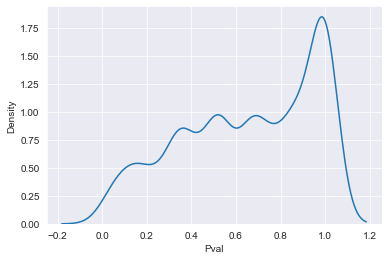

Abundance,s__Phocaeicola_dorei,s__Phocaeicola_massiliensis,s__Bacteroides_stercoris,s__Sutterella_wadsworthensis,s__Parabacteroides_merdae,s__Bacteroides_faecis,s__Bifidobacterium_longum,s__Flavonifractor_plautii,s__Blautia_wexlerae,s__Ruminococcus_gnavus,...,s__GGB9632_SGB15089,s__Alistipes_putredinis,s__Faecalibacillus_intestinalis,s__Bacteroides_cellulosilyticus,s__Alistipes_finegoldii,s__Bacteroides_intestinalis,s__Ruminococcus_bromii,s__Anaerotignum_lactatifermentans,s__Acidaminococcus_intestini,s__Bifidobacterium_dentium
External ID,,,,,,,,,,,,,,,,,,,,,
MSM79HBX_P,0,0,1,1,1,0,1,0,0,0,...,0,1,1,1,0,0,0,0,0,1
MSM9VZM4_P,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
HSM5MD5X_P,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
HSM7CZ2V_P,1,1,1,0,1,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
ESM5MEB9_P,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PSM6XBQM_P,1,1,0,1,0,1,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
PSM6XBRK_P,1,1,1,1,1,1,0,1,1,0,...,1,0,0,0,0,0,0,1,1,0
PSM6XBRM_P,1,0,0,1,0,1,0,0,0,1,...,0,1,0,1,1,0,1,0,0,0
PSM6XBVY_P,0,0,1,0,1,0,0,1,1,0,...,1,1,1,0,0,1,1,0,1,0


In [232]:
j_CD = M_CD.astype(int)
j_UC = M_UC.astype(int)
j_Control = M_Control.astype(int)
T_CD = create_jaccard_pvals_table(j_CD)
T_UC = create_jaccard_pvals_table(j_UC)
T_Control = create_jaccard_pvals_table(j_Control)
sns.kdeplot(T_CD.Pval)
plt.show()
# .loc[:,['s__Oscillibacter_sp_ER4','s__GGB9615_SGB15053']]

In [239]:
T_CD

,Species1,Species2,Jaccard,Pval,FDR
0,s__Phocaeicola_dorei,s__Lacrimispora_amygdalina,1.0,0.003968,1.0
1,s__Lachnospiraceae_bacterium,s__Firmicutes_bacterium_AF16_15,1.0,0.004762,1.0
2,s__Odoribacter_splanchnicus,s__Alistipes_putredinis,1.0,0.004762,1.0
3,s__Alistipes_communis,s__Faecalibacillus_intestinalis,1.0,0.022222,1.0
4,s__Veillonella_parvula,s__Agathobaculum_butyriciproducens,1.0,0.022222,1.0
...,...,...,...,...,...
2696,s__Bifidobacterium_pseudocatenulatum,s__Ruminococcus_bromii,0.0,1.000000,1.0
2697,s__Bifidobacterium_pseudocatenulatum,s__Alistipes_finegoldii,0.0,1.000000,1.0
2698,s__Veillonella_parvula,s__Coprococcus_comes,0.0,1.000000,1.0
2699,s__Bifidobacterium_pseudocatenulatum,s__GGB9615_SGB15053,0.0,1.000000,1.0


In [247]:
T_CD.loc[(T_CD.Species1 == 's__Flavonifractor_plautii') & (T_CD.Species2 =='s__Dysosmobacter_welbionis'),:]

,Species1,Species2,Jaccard,Pval,FDR
396,s__Flavonifractor_plautii,s__Dysosmobacter_welbionis,0.4,0.333333,1.0


In [248]:
print(sum(M_CD.s__Dysosmobacter_welbionis > 0.1))
print(sum(M_CD.s__Flavonifractor_plautii > 0.1))
print(sum((M_CD.s__Flavonifractor_plautii > 0.1)*(M_CD.s__Dysosmobacter_welbionis > 0.1)))

3
4
2


In [249]:
Cluster_CD = Metaphlan4_pilot.loc[:,['s__Dysosmobacter_welbionis','s__Flavonifractor_plautii']]
# Cluster_CD = Metaphlan4_pilot.loc[:,['s__Oscillibacter_sp_ER4','s__GGB9615_SGB15053']]

In [250]:
Name_Hierarchical_CD = pd.read_csv('~/Desktop/Metaphlan4_set_species_CD.csv')
Name_Hierarchical_CD.set_index('Unnamed: 0',inplace=True)
sum_samples = pd.DataFrame(M_CD.sum())
HCD = Cluster_CD.T.join(sum_samples)
Hierarchical_CD = HCD.join(Name_Hierarchical_CD)
Hierarchical_CD.rename(columns={Hierarchical_CD.columns[-1]:'Hierarchical', Hierarchical_CD.columns[-2]:'Sum_Samples'}, inplace=True)
Hierarchical_CD

,PSM7J13U_P,CSM7KONS_P,HSM7CZ1T_P,HSM5MD4W_P,MSM5LLGJ_P,MSM9VZN4_P,ESM5MEEJ_P,CSM5MCXX_P,CSM5FZ3X_P,MSM5LLGR_P,...,MSM5LLIQ_P,HSM67VDX_P,MSM5LLF2_P,ESM5GEZ6_P,ESM5MEDZ_P,MSM5LLFG_P,CSM5MCYU_P,ESM5GEYX_P,Sum_Samples,Hierarchical
Abundance,,,,,,,,,,,,,,,,,,,,,
s__Dysosmobacter_welbionis,NaN,0.43507,0.43202,0.25212,0.37516,0.0150,0.32288,0.72625,0.00000,2.56915,...,0.0,0.33905,1.28437,1.54776,0.00000,1.89565,1.22148,0.01496,3.0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
s__Flavonifractor_plautii,1.03482,0.05540,0.21906,0.79191,0.18662,0.0142,0.73405,0.26472,0.12731,0.89729,...,0.0,0.27635,2.21187,1.76301,0.02539,0.77432,0.41855,0.00000,4.0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
